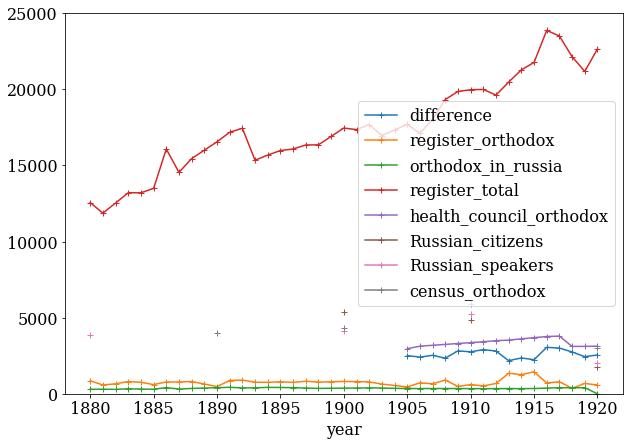

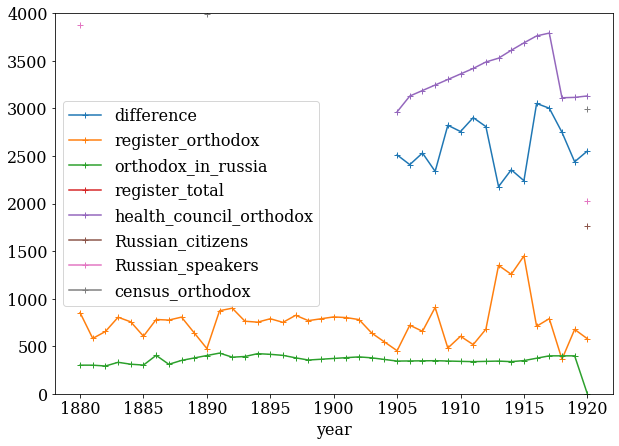

In [64]:
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_dir = Path('../data')
figure_dir = Path('../figures')
figure_dir.mkdir(exist_ok=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

district_codes = pd.read_csv(data_dir / 'district_codes_1878.csv')
district_codes = {k: v for k, v in district_codes.itertuples(index=False)}
institutions = pd.read_csv(data_dir / 'institutions.csv', dtype={'district': str, 'plot_number': str})

districts_in_city = [
    'Valli',
    'Salakkalahti',
    'Repola',
    'Anina',
    'Papula',
    'P_Annan_kruunu',
    'Hiekka',
    'Pantsarlahti',
    'Viipurin_esikaupunki',
    'Paulovski',
    'Havi',
    'Saunalahti',
    'Pietarin_esikaupunki',
]

poll_tax = pd.read_csv(data_dir / 'poll_tax_register.csv', index_col=0)
poll_tax['orthodox'] = poll_tax['orthodox'].interpolate(method='linear')
poll_tax['in_russia_orthodox'] = poll_tax['in_russia_orthodox'].interpolate(method='linear', limit=2).fillna(0)
poll_tax['total'] = (poll_tax.total_women + poll_tax.total_men).interpolate(method='linear')
remove = poll_tax.in_russia_orthodox.copy()
remove.loc['1906':] = 0
poll_tax['orthodox'] = poll_tax.orthodox - remove
health_council = pd.read_csv(data_dir / 'health_council.csv', index_col=0).pop_orthodox
health_council = health_council.reindex(range(1880, 1921), fill_value=np.nan).interpolate(method='slinear')
foreigners = pd.read_csv(data_dir / 'foreigners.csv', index_col=0).russia
language = pd.read_csv(data_dir / 'language.csv', index_col=0).russian
religion = pd.read_csv(data_dir / 'religion.csv', index_col=0).orthodox
difference = health_council - poll_tax.orthodox
data = pd.DataFrame([
    difference,
    poll_tax.orthodox,
    poll_tax.in_russia_orthodox,
    poll_tax.total,
    health_council,
    foreigners,
    language,
    religion,
]).T
data.columns = [
    'difference',
    'register_orthodox',
    'orthodox_in_russia',
    'register_total',
    'health_council_orthodox',
    'Russian_citizens',
    'Russian_speakers',
    'census_orthodox',
]
# data.interpolate(method='linear', inplace=True)
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 25_000))
plt.savefig(figure_dir / 'timeseries1.png')
data.plot(marker='+', legend=True, figsize=(10, 7), ylim=(0, 4_000))
plt.savefig(figure_dir / 'timeseries2.png')

## Fourier analysis

No few-year clear cycle detectable

[20.5        13.66666667 10.25        8.2         6.83333333  5.85714286
  5.125       4.55555556  4.1         3.72727273  3.41666667  3.15384615
  2.92857143  2.73333333  2.5625      2.41176471  2.27777778  2.15789474
  2.05      ]


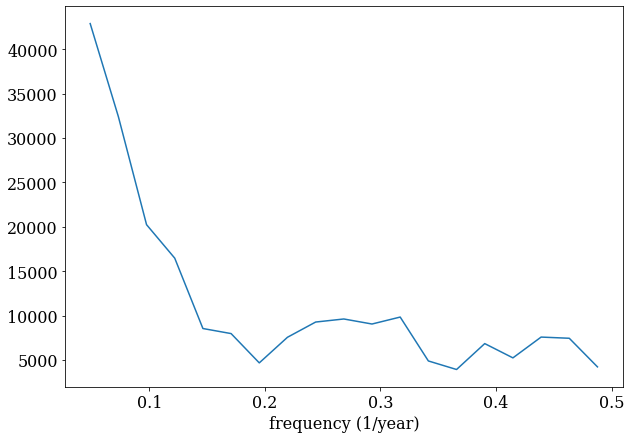

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq

ft = np.abs(rfft(data['register_total']))[2:]
freq = rfftfreq(len(data.index))[2:]

plt.figure(figsize=(10, 7))
plt.plot(freq, ft)

plt.xlabel('frequency (1/year)')
# plt.show()
plt.savefig(figure_dir / 'fourier.png')

print(1/freq)

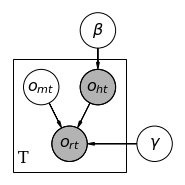

In [66]:
import daft
from matplotlib import rc

rc("font", family="serif", size=16)
scale = 1.25
pgm = daft.PGM()

# pgm.add_node('sigma', r'$\sigma_{\beta}$', 1, 3, fixed=True)
# pgm.add_node('mu', r'$\mu_{\beta}$', 2, 4, fixed=True)
pgm.add_node('health_orthodox', r'$o_{ht}$', 2, 2, fixed=False, scale=scale, observed=True)
pgm.add_node('register_orthodox', r'$o_{rt}$', 1.5, 1, fixed=False, scale=scale, observed=True)
pgm.add_node('missing_orthodox', r'$o_{mt}$', 1, 2, fixed=False, scale=scale, observed=False)
pgm.add_node('beta_orthodox_city', r'$\beta$', 2, 3, fixed=False, scale=scale, observed=False)
pgm.add_node('gamma', r'$\gamma$', 3, 1, fixed=False, scale=scale, observed=False)

# pgm.add_edge('sigma', 'beta_orthodox_city', directed=True)
# pgm.add_edge('mu', 'beta_orthodox_city', directed=True)
pgm.add_edge('beta_orthodox_city', 'health_orthodox', directed=True)
pgm.add_edge('gamma', 'register_orthodox', directed=True)
pgm.add_edge('health_orthodox', 'register_orthodox', directed=True)
pgm.add_edge('missing_orthodox', 'register_orthodox', directed=True)

pgm.add_plate([0.5, 0.5, 2, 2], 'T')

pgm.render()

Model:

$ o_{rt} = \gamma o_{ht} - o_{mt} $

$ \gamma \sim N(0.8, 0.1^2) $

$ o_{mt} \sim N(0.5, 0.1^2) $

$ o_{ht} \sim N(\mu_{o_{ht}}, 0.01^2) $

$ \mu_{o_{ht}} = \beta_0 + \beta_1 t $

$ \beta \sim N\begin{pmatrix}\begin{bmatrix} 0.75 \\ 0.02 \end{bmatrix},
 \begin{bmatrix} 0.02 && 0 \\ 0 && 0.002 \end{bmatrix}\end{pmatrix} $

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 16200
Interrupted at 16,199 [8%]: Average Loss = 2.8039e+05
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta_health_1, beta_health_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8788698592130191, but should be close to 0.8. Try to increase the number of tuning steps.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

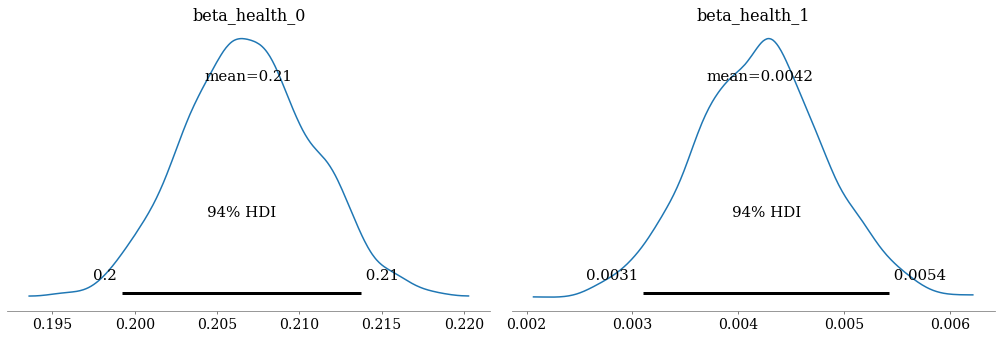

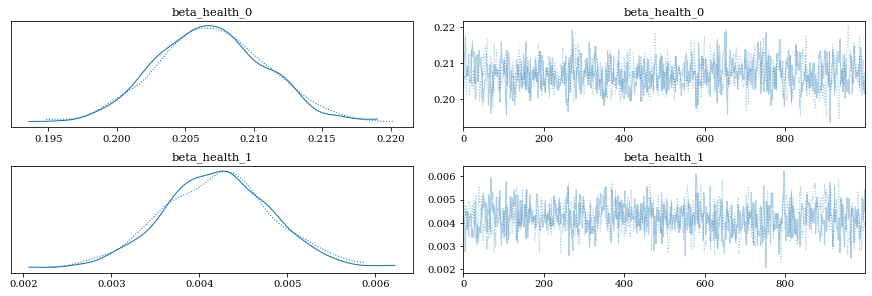

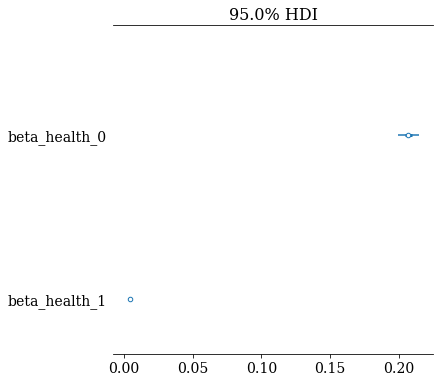

In [67]:
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

data_pm = data.iloc[26:-3,]
standard = 15_000
data_pm = data_pm / standard
start = 1906
data_pm['t'] = data_pm.index - start

with pm.Model() as model_health_council_orthodox:
    n, _ = data_pm.shape
    t = np.asarray(data_pm.t)
    beta_health_0 = pm.Normal(
        "beta_health_0",
        mu=0.2,
        sigma=0.01,
    )
    beta_health_1 = pm.Normal(
        "beta_health_1",
        mu=0.004,
        sigma=0.001,
    )
    # mu_health = tt.add(beta_health_0, tt.mul(beta_health_1, data_pm.t))
    mu_health = beta_health_0 + t * beta_health_1
    # sigma_total = pm.Exponential('sigma_total', 100)
    health_council = pm.Normal(
        'health_council',
        mu=mu_health,
        sigma=0.01,
        observed=np.asarray(data_pm.health_council_orthodox),
    )

    trace_health = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior_health = pm.sample_prior_predictive()
    posterior_health = pm.sample()
    posterior_pred_health = pm.sample_posterior_predictive(posterior_health)

az.plot_posterior(posterior_health)
az.plot_trace(posterior_health)
az.plot_forest(posterior_health, combined=True, hdi_prob=0.95)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [theta]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_orthodox, beta_orthodox_1, beta_orthodox_0]
>BinaryGibbsMetropolis: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.


array([<AxesSubplot:title={'center':'95.0% HDI'}>], dtype=object)

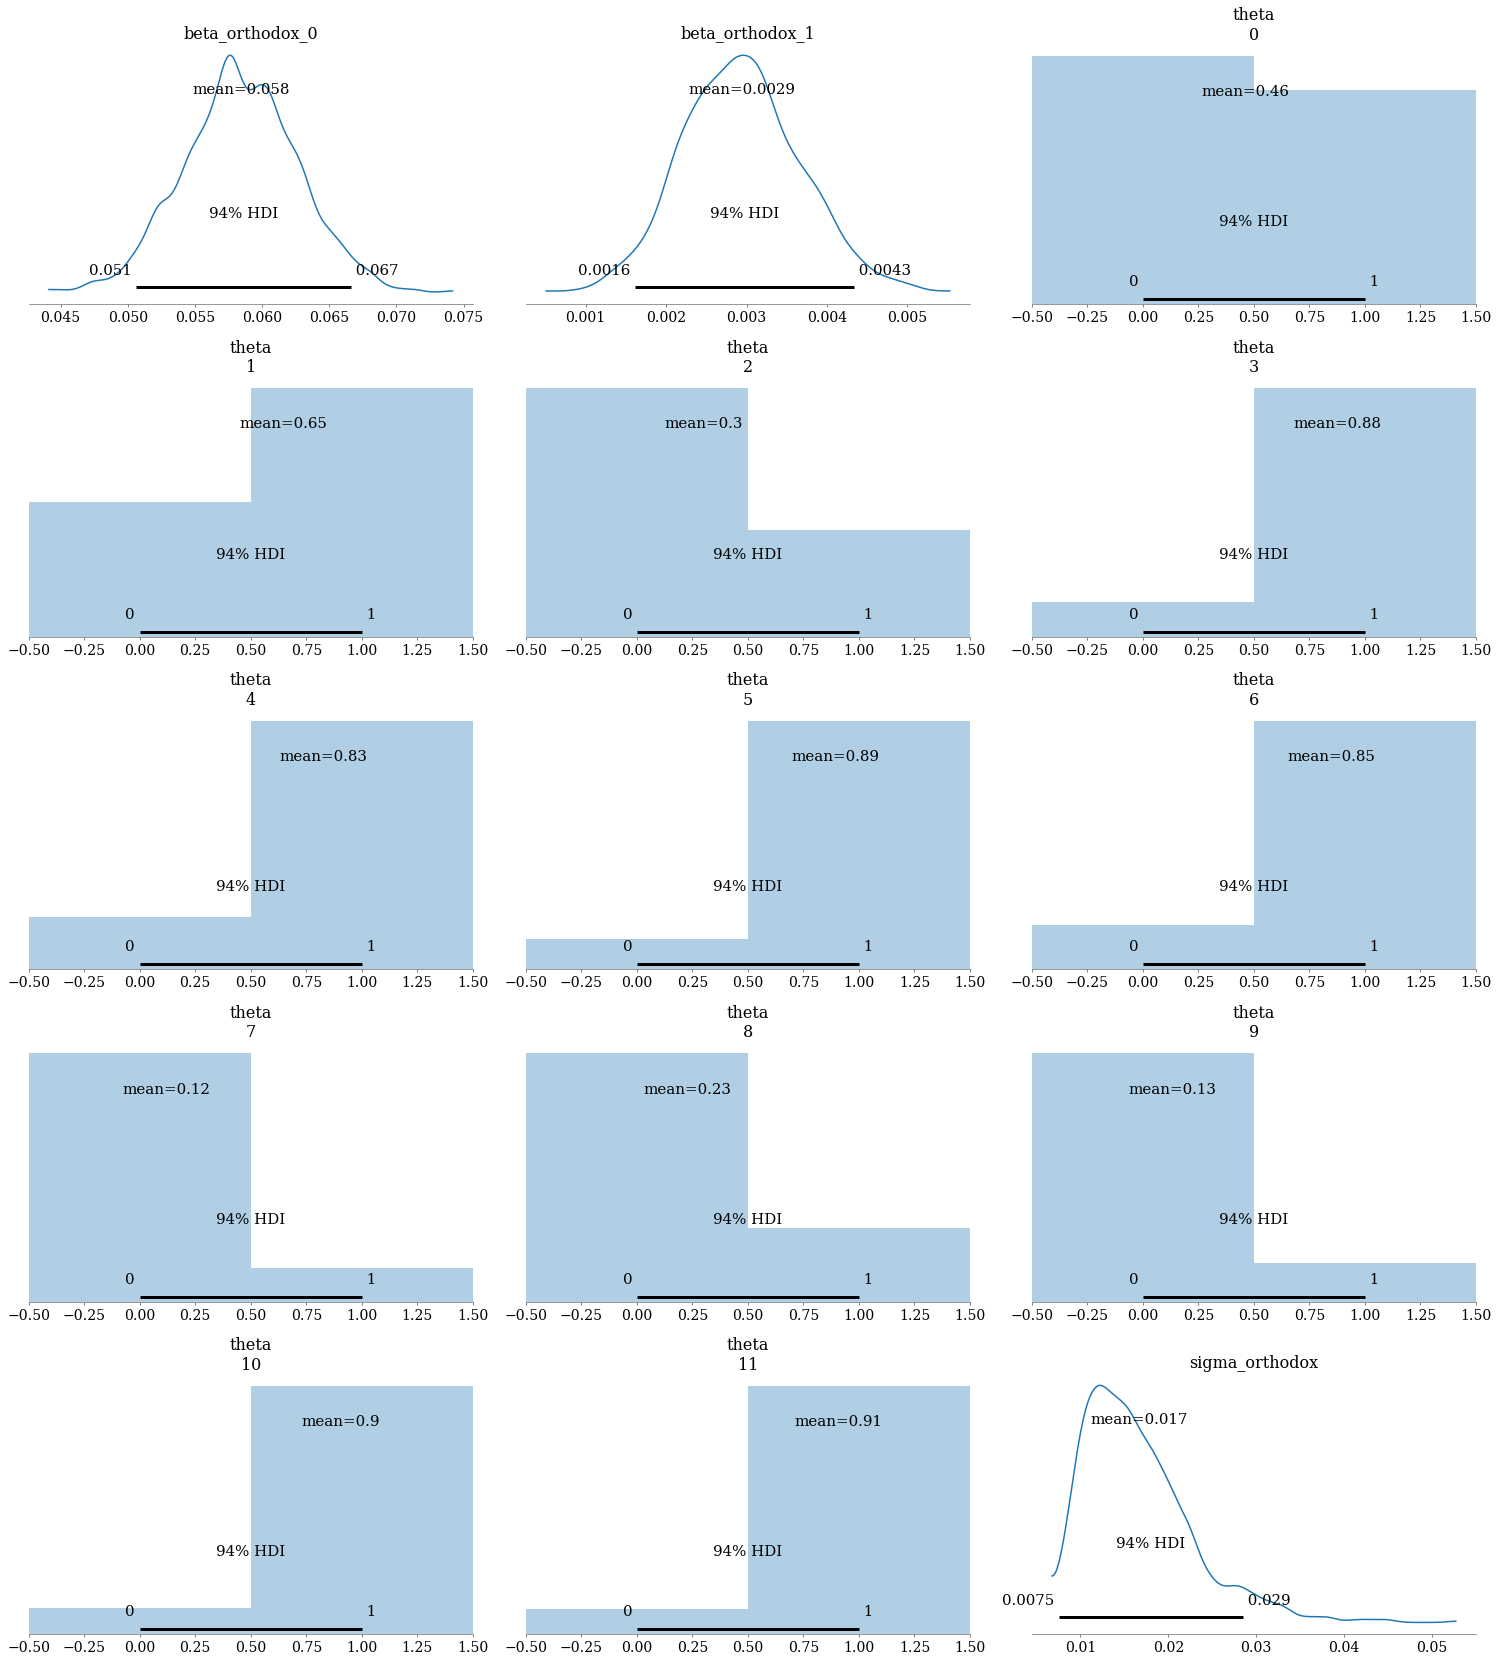

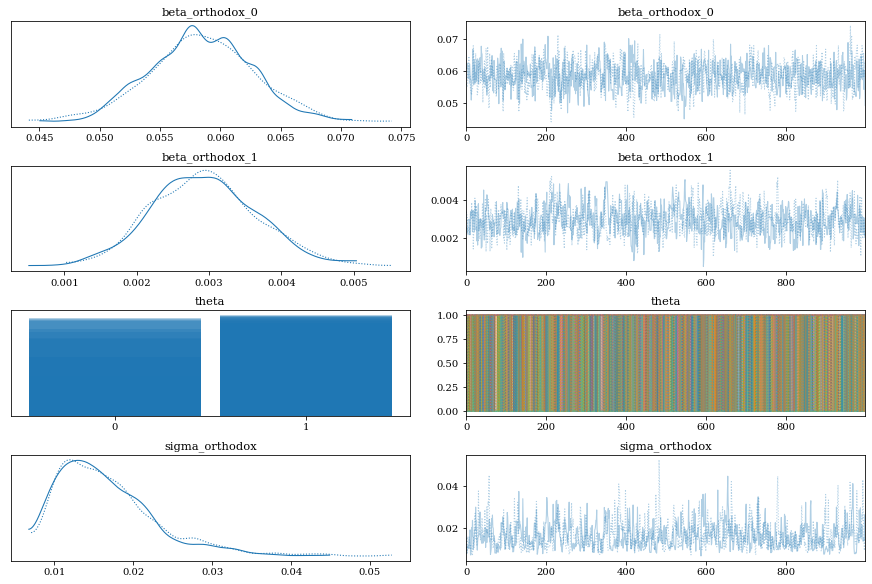

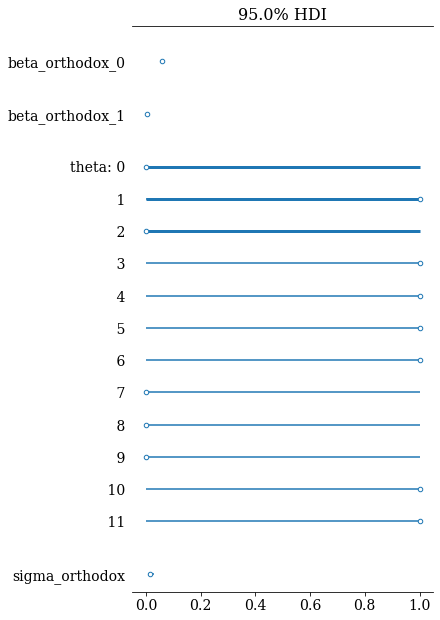

In [68]:
mu_beta_orthodox_0 = 0.21 * 0.3
mu_beta_orthodox_1 = 0.004

with pm.Model() as model_orthodox:
    beta_orthodox_0 = pm.Normal(
        "beta_orthodox_0",
        mu=mu_beta_orthodox_0,
        sigma=0.005,
    )
    beta_orthodox_1 = pm.Normal(
        "beta_orthodox_1",
        mu=mu_beta_orthodox_1,
        sigma=0.001,
    )
    # theta = [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1]
    theta = pm.Bernoulli('theta', p=0.5, shape=n)
    sigma_total = pm.Exponential('sigma_orthodox', 10)
    missing = np.asarray(data_pm.orthodox_in_russia) * theta
    mu_total = beta_orthodox_0 + beta_orthodox_1 * t - missing
    total = pm.Normal(
        'total',
        mu=mu_total,
        sigma=sigma_total,
        observed=data_pm.register_orthodox,
    )

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")
    prior = pm.sample_prior_predictive()
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

az.plot_posterior(posterior)
az.plot_trace(posterior)
az.plot_forest(posterior, combined=True, hdi_prob=0.95)

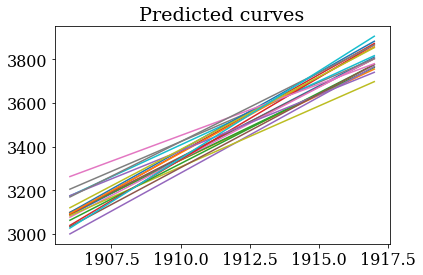

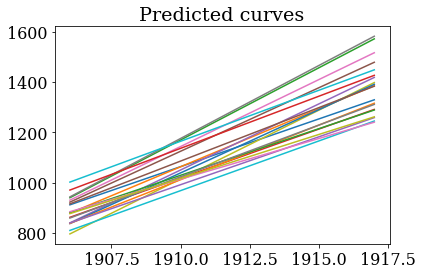

In [69]:
def plot_prediction(
        data,
        intercept_col,
        slope_col,
        standard,
        skip=100,
        start=1906,
        end=1918,
):
    year = np.arange(start, end, 1)
    intercept = data[intercept_col][::skip, ] * standard
    t = data[slope_col][::skip, ] * standard

    for sample in zip(intercept, t):
        total = sample[0] + sample[1] * (year - start)
        plt.plot(year, total)
    plt.title(f'Predicted curves')
    plt.show()

plot_prediction(
    posterior_health,
    intercept_col='beta_health_0',
    slope_col='beta_health_1',
    standard=standard,
    start=start,
)

plot_prediction(
    posterior,
    intercept_col='beta_orthodox_0',
    slope_col='beta_orthodox_1',
    standard=standard,
    start=start,
)

year
1906    0.048067
1907    0.043800
1908    0.060533
1909    0.032067
1910    0.040333
1911    0.034467
1912    0.045267
1913    0.090000
1914    0.083733
1915    0.096600
1916    0.047333
1917    0.052667
Name: register_orthodox, dtype: float64


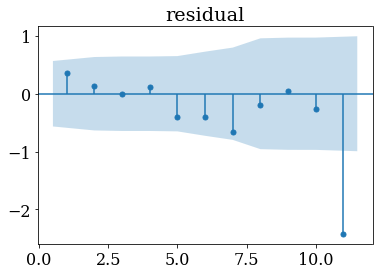

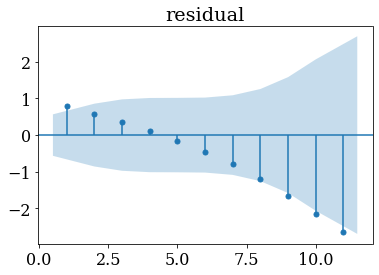

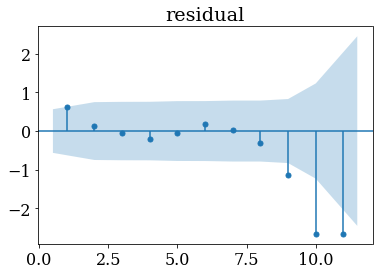

In [70]:
from statsmodels.graphics.tsaplots import plot_acf

data_pm['total_residual'] = data_pm.register_total - (data_pm.t * 0.016 + 0.84)
data_pm['orthodox_residual'] = data_pm.register_orthodox - (data_pm.t * 0.1 + 0.0037)
data_pm['health_council_orthodox_residual'] = data_pm.health_council_orthodox - (data_pm.t * 0.0043 + 0.09)
plot_acf(data_pm.health_council_orthodox_residual[-13:], title='residual', adjusted=True, zero=False)
plot_acf(data_pm.orthodox_residual, title='residual', adjusted=True, zero=False)
plot_acf(data_pm.total_residual, title='residual', adjusted=True, zero=False)
print(data_pm.register_orthodox)